In [1]:
# -*- coding : utf-8 -*-
### IMPORTATION
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
import sys

# VARIATIONNAL APPROACH

 dynamic :
 $$
\begin{cases}
 \displaystyle \frac{\partial y}{\partial t}(x,t) - b \frac{\partial y} {\partial x}(x,t) = 0, & (x,t) \in (0,\ell) \times (0,T)  \\[0.1cm]
 y(x,0) = y_{0} (x)  \\
 y(L,t) = 0
\end{cases}
$$

observations : $$ \mu ^k (t) = \int_0^{\infty} x^k y(x,t) \mathrm{dx}$$



In [2]:
class Foo():

    def __init__(self):
        ### PHYSICAL PARAMETERS
        b = 0.2  # Depolymerisation speed
        L = 1.0  # Domain size
        T = 5.0  # Integration time

        ### NUMERICAL PARAMETERS
        self.NT = 50  # Number of time steps
        self.NX = 50   # Initial number of grid points

        ### OBSERVER - MOMENT OPERATOR
        # First moment
        operator_moment_1= L/self.NX*np.linspace(0, L, self.NX)
        # Second moment
        operator_moment_2= L/self.NX*np.square(np.linspace(0, L, self.NX))
        # Concatenate
        self.observer = np.vstack((operator_moment_1, operator_moment_2))
        self.observer_transpose = np.transpose(self.observer)

        ### DYNAMIC FLOW PHI
        CFL = b*(T/self.NT)*(self.NX/L)
        self.flow = np.eye(self.NX,self.NX) + CFL*(-np.eye(self.NX,self.NX) + np.diag(np.ones(self.NX-1),1))
        self.flow_transpose = np.eye(self.NX,self.NX) + CFL*(-np.eye(self.NX,self.NX) + np.diag(np.ones(self.NX-1),-1))

        ### INITIAL CONDITION
        self.x = np.linspace(0.0,L,self.NX+1)
        self.t = np.linspace(0.0,T,self.NT+1)
        sigma = L/10
        self.gaussienne = (sigma*np.sqrt(2*np.pi))**-1*np.exp(-(self.x-L/2)**2/(2*sigma**2)) # Gaussienne
        self.gaussienne[self.NX] = 0

        ### GRADIENT PARAMETER
        self.iteration_max = 100
        self.gamma = 10000000
        self.alpha = 1

        ### NORM
        # Construction of the norm of the two spaces
        self.norm_observation = T/self.NT*np.eye(2)
        self.inv_norm_observation = 1/(T/self.NT)*np.eye(2)
        self.norm_state = (L/self.NX)*np.eye(self.NX)
        self.inv_norm_state = (self.NX/L)*np.eye(self.NX)


The solution $y$ of the transport equation is discretized with the finite difference method. Therefore for each control point $(x_i)_{i \in [0,N_X]}$, $y$ is approximated by the piecewise linear function on $[x_i,x_{i+1}]$ for all $i$ in $[0,N_X-1]$ of size $h$. 
Then, using a forward difference at time $t_n$ and $ \delta t = t_{n+1}-t_n$ :

$$ \forall n \in [0,N_T-1] \quad \forall i \in [0,N_X-1] \quad \frac{y_{i}^{n+1}-y_{i}^n}{\delta t} - b \frac{y_{i+1}^n - y_{i}^n}{h} = 0 $$

Then we defined the matrix of observation :

$$ C =  \left( \begin{array}{cc}
	h x_0       &  h x_0^2   \\
	h x_1       &  h x_1^2   \\
	\vdots      & \vdots     \\
	h x_{NX-1}  & h x_{NX-1}^2
	 \end{array} \right). $$

And starting with a gaussian initial condition we generate two moments.

In [3]:
def DataGeneration():

    ### DOWNLOADING PARAMETERS
    foo = Foo()

    ### VECTOR INITIALISATION
    state = np.zeros((foo.NX,foo.NT+1)) # Saving the solution of the transport equation
    state[:,0] = foo.gaussienne[:-1].copy()
    mu = np.zeros((2,foo.NT+1)) # First and second order moment

    ### DIRECT COMPUTATION OF THE SOLUTION
    for i in range(0,foo.NT):
        # Calculation of the moment
        mu[:,i] = np.dot(foo.observer,state[:,i])
        # Dynamic computation
        state[:,i+1] = np.dot(foo.flow,state[:,i]) 

    # Return observation vector
    return mu



No handles with labels found to put in legend.


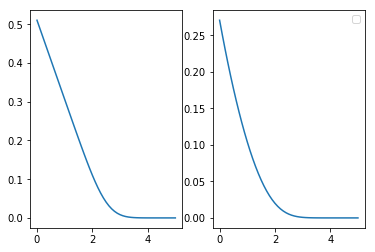

In [4]:
### PLOTS
foo = Foo()
mu = DataGeneration()


fig = plt.figure()
mu1 = fig.add_subplot(121)
mu2 = fig.add_subplot(122)

mu1.plot(foo.t, mu[0,:])
mu2.plot(foo.t, mu[1,:])

plt.legend()
plt.show()

In [5]:
def CriterionJ(zeta):

    ### DOWNLOADING PARAMETERS
    foo = Foo()

    ### DOWNLOADING OBSERVATIONS
    mu = DataGeneration()

    ### MATRIX COMPUTATION
    # Computation of the Hessian A
    A_quadratic = foo.alpha*foo.norm_state.copy()
    A_inter = foo.gamma*foo.observer_transpose.dot(foo.norm_observation).dot(foo.observer)
    A_quadratic += A_inter
    for i in range(1,foo.NT+1):
        A_inter = foo.flow_transpose.dot(A_inter).dot(foo.flow)
        A_quadratic += A_inter

    # Computation of b
    # No a priori on the initial solution (equal to zero)
    state_apriori = np.zeros((foo.NX,foo.NT+1))
    b_linear = foo.gamma*foo.observer_transpose.dot(foo.norm_observation)\
    .dot(mu[:,0]- foo.observer.dot(state_apriori[:,0]))
    for j in range(1,foo.NT+1):
        state_apriori[:,j] = foo.flow.dot(state_apriori[:,j-1])
        b_inter = foo.gamma*foo.observer_transpose.dot(foo.norm_observation)\
        .dot(mu[:,j]-foo.observer.dot(state_apriori[:,j]))
        for k in range(1,j+1):
            b_inter = foo.flow_transpose.dot(b_inter)
        b_linear += b_inter

    ### CRITERION COMPUTATION
    # Computimg J = 1/2<Azeta,zeta> - <b,zeta> size 1,1
    J = (1/2)*np.transpose(zeta).dot(A_quadratic).dot(zeta) \
    - np.transpose(b_linear).dot(zeta)

    return J

In [6]:
def CriterionGrad(zeta):

    ### DOWNLOADING PARAMETERS
    foo = Foo()

    ### DOWNLOADING OBSERVATIONS
    mu = DataGeneration()

    ### MATRIX COMPUTATION
    # Computation of the Hessian A
    A_quadratic = foo.alpha*foo.norm_state.copy()
    A_inter = foo.gamma*foo.observer_transpose.dot(foo.norm_observation).dot(foo.observer)
    A_quadratic += A_inter
    for i in range(1,foo.NT+1):
        A_inter = foo.flow_transpose.dot(A_inter).dot(foo.flow)
        A_quadratic += A_inter

    # Computation of b
    # No a priori on the initial solution (equal to zero)
    state_apriori = np.zeros((foo.NX,foo.NT+1))
    b_linear = foo.gamma*foo.observer_transpose.dot(foo.norm_observation)\
    .dot(mu[:,0]- foo.observer.dot(state_apriori[:,0]))
    for j in range(1,foo.NT+1):
        state_apriori[:,j] = foo.flow.dot(state_apriori[:,j-1])
        b_inter = foo.gamma*foo.observer_transpose.dot(foo.norm_observation)\
        .dot(mu[:,j]-foo.observer.dot(state_apriori[:,j]))
        for k in range(1,j+1):
            b_inter = foo.flow_transpose.dot(b_inter)
        b_linear += b_inter

    ### CRITERION COMPUTATION
    # Computimg GradJ = Azeta - b size 1,NX-1
    GradJ = A_quadratic.dot(zeta) - b_linear

    return GradJ

In [7]:
def CriterionHess(zeta):

    ### DOWNLOADING PARAMETERS
    foo = Foo()

    ### MATRIX COMPUTATION
    # Computation of the Hessian A
    A_quadratic = foo.alpha*foo.norm_state.copy()
    A_inter = foo.gamma*foo.observer_transpose.dot(foo.norm_observation).dot(foo.observer)
    A_quadratic += A_inter
    for i in range(1,foo.NT+1):
        A_inter = foo.flow_transpose.dot(A_inter).dot(foo.flow)
        A_quadratic += A_inter

    return A_quadratic

## Newton algorithm (N-CG)

In [8]:
zeta0 = np.zeros(foo.NX)
res = minimize(CriterionJ, zeta0, method='Newton-CG',\
               jac=CriterionGrad, hess=CriterionHess,\
               options = {'xtol': 0.01, 'disp': True} )


Optimization terminated successfully.
         Current function value: -1372222.256923
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 16
         Hessian evaluations: 8


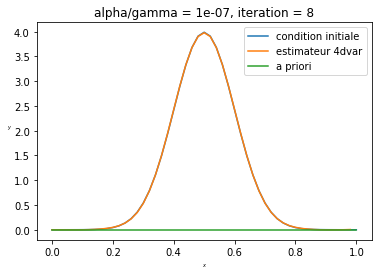

In [9]:
plt.xlabel(u'$x$', fontsize=5)
plt.ylabel(u'$y$', fontsize=5, rotation=0)
plt.title("alpha/gamma = {0}, iteration = {1}"\
.format(foo.alpha/foo.gamma, res.nit))
p0 = plt.plot(foo.x, foo.gaussienne, label= "condition initiale")
p1 = plt.plot(foo.x[:-1], res.x, label= "estimateur 4dvar")
p2 = plt.plot(foo.x, np.zeros(foo.NX+1), label= "a priori")
plt.legend()
plt.show()

## Broyden-Fletcher-Goldfarb-Shanno algorithm (BFGS)

In [10]:
zeta0 = np.zeros(foo.NX)
res = minimize(CriterionJ, zeta0, method='BFGS',\
               jac=CriterionGrad, options={'disp': True})

         Current function value: -1372222.257528
         Iterations: 18
         Function evaluations: 65
         Gradient evaluations: 54


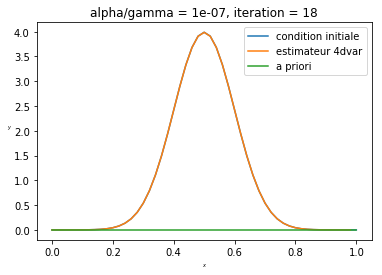

In [11]:
plt.xlabel(u'$x$', fontsize=5)
plt.ylabel(u'$y$', fontsize=5, rotation=0)
plt.title("alpha/gamma = {0}, iteration = {1}"\
.format(foo.alpha/foo.gamma, res.nit))
p0 = plt.plot(foo.x, foo.gaussienne, label= "condition initiale")
p1 = plt.plot(foo.x[:-1], res.x, label= "estimateur 4dvar")
p2 = plt.plot(foo.x, np.zeros(foo.NX+1), label= "a priori")
plt.legend()
plt.show()

## Trust-Region Newton-Conjugate-Gradient algorithm

In [12]:
zeta0 = np.zeros(foo.NX)
res = minimize(CriterionJ, zeta0, method='trust-ncg',\
                   jac=CriterionGrad, hess=CriterionHess,\
                   options={'gtol': 1e-8, 'disp': True})

         Current function value: -1372222.257528
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 16
         Hessian evaluations: 16


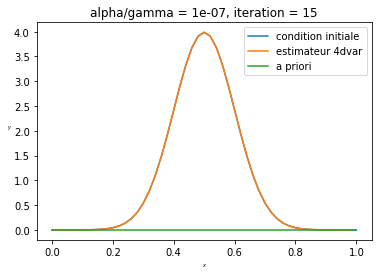

In [13]:
plt.xlabel(u'$x$', fontsize=5)
plt.ylabel(u'$y$', fontsize=5, rotation=0)
plt.title("alpha/gamma = {0}, iteration = {1}"\
.format(foo.alpha/foo.gamma, res.nit))
p0 = plt.plot(foo.x, foo.gaussienne, label= "condition initiale")
p1 = plt.plot(foo.x[:-1], res.x, label= "estimateur 4dvar")
p2 = plt.plot(foo.x, np.zeros(foo.NX+1), label= "a priori")
plt.legend()
plt.show()